In [1]:
import skimage.io
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pickle

In [2]:
class TileMaker:
    
    def __init__(self, size, number):
        self.size = size
        self.number = number
        
    def make(self, image, mask):
        
        h, w, c = image.shape
        horizontal_pad = 0 if (w % self.size) == 0 else self.size - (w % self.size)
        vertical_pad = 0 if (h % self.size) == 0 else self.size - (h % self.size)
        
        image = np.pad(image, pad_width=((vertical_pad//2, vertical_pad - vertical_pad//2), 
                                         (horizontal_pad//2, horizontal_pad - horizontal_pad//2),
                                         (0, 0)), 
                       mode='constant', constant_values=255)  # Empty is white in this data
        
        mask = np.pad(mask, pad_width=((vertical_pad//2, vertical_pad - vertical_pad//2), 
                                       (horizontal_pad//2, horizontal_pad - horizontal_pad//2),
                                       (0, 0)), 
                       mode='constant', constant_values=0)  # Empty is black in this data
        
        h, w, c = image.shape
        image = image.reshape(h // self.size, self.size, w // self.size, self.size, c)
        image = image.swapaxes(1, 2).reshape(-1, self.size, self.size, c)
        mask = mask.reshape(h // self.size, self.size, w // self.size, self.size, c)
        mask = mask.swapaxes(1, 2).reshape(-1, self.size, self.size, c)
        
        if image.shape[0] < self.number:
            image = np.pad(image, pad_width=((0, self.number - image.shape[0]), (0, 0), (0, 0), (0 ,0)),
                           mode='constant', constant_values=255)
            mask = np.pad(mask, pad_width=((0, self.number - mask.shape[0]), (0, 0), (0, 0), (0 ,0)),
                          mode='constant', constant_values=0)
        
        # Find the images with the most stuff (the most red):
        sorted_tiles = np.argsort(np.sum(image[:, :, :, 0:1], axis=(1, 2, 3)))
        sorted_tiles = sorted_tiles[:self.number]
        
        return image[sorted_tiles], mask[sorted_tiles]

In [3]:
BASE_PATH = Path('G:/Datasets/panda/')
OUTPUT_BASE = Path('D:/Datasets/panda/')

TRAIN_PATH = BASE_PATH/'train_images/'
MASKS_TRAIN_PATH = BASE_PATH/'train_label_masks/'
OUTPUT_IMG_PATH = OUTPUT_BASE/'train_tiles_256_2/imgs/'
OUTPUT_MASK_PATH = OUTPUT_BASE/'train_tiles_256_2/masks/'
CSV_PATH = BASE_PATH/'train.csv'
LEVEL = -2

In [4]:
OUTPUT_IMG_PATH.mkdir(exist_ok=True, parents=True)
OUTPUT_MASK_PATH.mkdir(exist_ok=True, parents=True)

In [5]:
tile_maker = TileMaker(256, 12)

In [7]:
img_list = list(TRAIN_PATH.glob('**/*.tiff'))
#img_list.pop(5765)
bad_images = []
bad_masks = []
image_stats = []
for i, img_fn in enumerate(img_list):
    
    img_id = img_fn.stem
    mask_fn = MASKS_TRAIN_PATH/(img_id + '_mask.tiff')
    
    try:
        col = skimage.io.MultiImage(str(img_fn))
        image = col[LEVEL]
    except:
        bad_images.append(img_id)
        continue
    
    if mask_fn.exists():
        
        try:
            mask = skimage.io.MultiImage(str(mask_fn))[LEVEL]
        except:
            bad_masks.append(img_id)
            mask = np.zeros_like(image)
            
    else:
        mask = np.zeros_like(image)
        
    image, mask = tile_maker.make(image, mask)
    sys.stdout.write(f'\r{i + 1}/{len(img_list)}')

    image_stats.append({'image_id': img_id, 'mean': image.mean(axis=(0, 1, 2))/255, 
                        'mean_square': ((image/255) ** 2).mean(axis=(0, 1, 2))})
    
    for i, (tile_image, tile_mask) in enumerate(zip(image, mask)):
        skimage.io.imsave(OUTPUT_IMG_PATH/(img_id + '_' + str(i) + '.png'), tile_image, check_contrast=False)
        skimage.io.imsave(OUTPUT_MASK_PATH/(img_id +'_' + str(i) + '.png'), tile_mask, check_contrast=False)

8/10616

KeyboardInterrupt: 

In [8]:
col_img = skimage.io.MultiImage(str(img_fn))
col_mask = skimage.io.MultiImage(str(mask_fn))

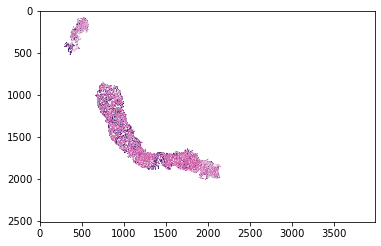

In [9]:
plt.imshow(col_img[1])

In [10]:
import matplotlib

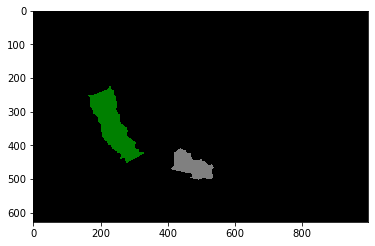

In [11]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.imshow(np.asarray(col_mask[2])[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
plt.show()

In [12]:
import cv2

In [13]:
col_img[1].dtype

dtype('uint8')

In [21]:
tile = col_img[1][1000:1512, 750:1262]

In [22]:
circles = cv2.HoughCircles(image=cv2.cvtColor(tile, cv2.COLOR_RGB2GRAY), method=cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50,param2=30,minRadius=0,maxRadius=0)

In [24]:
len(circles[0])

259

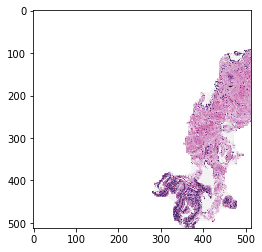

In [25]:
plt.imshow(tile)

In [17]:
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(tile,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(tile,(i[0],i[1]),2,(0,0,255),3)

cv2.imshow('detected circles',tile[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
image_stats = pd.DataFrame(image_stats)

In [12]:
df = pd.read_csv(CSV_PATH)
df = pd.merge(df, image_stats, on='image_id', how='left')

In [13]:
provider_stats = {}
for provider in df['data_provider'].unique():
    mean = (df[df['data_provider']==provider]['mean']).mean()
    std = np.sqrt((df[df['data_provider']==provider]['mean_square']).mean() - mean ** 2)
    provider_stats[provider] = (mean, std)
provider_stats['all'] = (mean, std)

In [14]:
with open(OUTPUT_BASE/'stats.pkl', 'wb') as file:
    pickle.dump(provider_stats, file)

In [15]:
print(bad_images)

[]


In [16]:
print(bad_masks)

['8d6d8329cd0bbf6d0356b300f83d6b6a', '8d9bf04e714c959d4c571030c51ee9f5', '8fa7f6ad508c78ef7dbd621d579350b8', '93e2ce38e743146a128afb9ff3a61383', '93f366029ac746d84ea2aea80cc998e8', '9403cc77efc7d9414204d12e31dadac1', '95deb0caf878d715c1a497a77abbd6d9', '95df6544155901a142acce3866e316c2', '96aac9c3672cadf72e9e60d634bb145a', '96c62d8799651597247be49bf790d585', '97a83309575b765469e6a09250d92170', '97bed3de5c372f3dc9ba818cd5e97369', '99bc60c2d554be9304993efa0a5ef740']


In [17]:
print(provider_stats)

{'karolinska': (array([0.87654091, 0.75072203, 0.84950648]), array([0.15320463, 0.29574767, 0.17975922])), 'radboud': (array([0.91472376, 0.83046245, 0.86723473]), array([0.11670425, 0.20455511, 0.15790534]))}
